# 2023 IEEE SciVis Contest
### Neuronal Network Simulations of the Human Brain

Authors: Seda den Boer, Dominique Weltevreden

Course: Scientific Visualisation and Virtual Reality, UvA

Semester: Fall 2023

#### Research question:
How does setting individual calcium targets for neurons influence the general brain activity and connectivity?

### Requirements:
Required packages and correct versions can be downloaded with `pip install -r requirements.txt`

#### Prerequisites:
* Create an empty `data` filemap.
* Download the 2023 IEEE SciVis Contest `viz-no-network` and `viz-calcium` data from the following page https://rwth-aachen.sciebo.de/s/KNTo1vgT0JZyGJx, and store it in `data` filemap.
* Unzip the monitors files.
* Make sure to create two new empty folders `monitors_extracted` and `files` in each simulation filemap.

Below the necessary data (filemaps) are shown:
```
└───data
    ├───viz-calcium
    │   ├───files
    │   ├───monitors
    │   │   • 0_{neuron_id}.csv
    │   ├───monitors_extracted
    │   └───positions
    │       • rank_0_positions.txt
    │   • calcium_targets.txt
    └───viz-no-network
        ├───files
        ├───monitors
        │   • 0_{neuron_id}.csv
        ├───monitors_extracted
        └───positions
            • rank_0_positions.txt
```

In [14]:
import numpy as np
import pandas as pd
from typing import List, Tuple
import os
import matplotlib.pyplot as plt

## Step 1: extracting relevant variable data from monitors files

In [15]:
def get_data(simulation_type: str, column_name: str) -> pd.DataFrame:
    """
    Get the data from the csv files and save it to a pickle file.

    Args:
        simulation_type (str): The type of simulation.
        column_name (str): The name of the column to extract.
    
    Returns:
        pd.DataFrame: The dataframe with the extracted data.
    """
    if simulation_type == 'no-network':
        file_directory = 'viz-no-network'
    elif simulation_type == 'calcium':
        file_directory = 'viz-calcium'

    gathered = []
    df_combined = pd.DataFrame()
    
    # Gather all the calcium levels
    for i in range(50000):
        # Get file path
        monitor_file = f'data/{file_directory}/monitors/0_{i}.csv'
        # Put it in a dataframe
        df = pd.read_csv(monitor_file, header=None, sep=';',
                         names=['step', f'fired_{i}', f'fired_fraction_{i}', f'x_{i}', f'secondary_variable_{i}',
                                f'calcium_{i}', f'target_calcium_{i}', f'synaptic_input_{i}', f'background_activity_{i}',
                                f'grown_axons_{i}', f'connected_axons_{i}', f'grown_excitatory_dendrites_{i}', f'connected_excitatory_dendrites_{i}'])

        # Set step column as [0, 100, 200, 300, ..., 1000000]
        df['step'] = np.arange(0, 1000000, 100)

        # Copy the last row to the end of the dataframe and increment the index
        df.loc[len(df)] = df.iloc[-1]

        # Set the step of the last row to 1000000
        df['step'].iloc[-1] = 1000000

        # Only keep the rows with step [0, 10000, 20000, ..., 1000000]
        df = df[df['step'] % 10000 == 0]

        # Add calcium levels to a list
        gathered.append(df[f'{column_name}_{i}'])

    # Combine all the calcium levels into a dataframe
    df_combined = pd.concat(gathered, axis=1)

    # Add steps as first column
    steps = np.arange(0, 1010000, 10000)
    df_combined.insert(0, 'step', steps)

    # Set step as the index column
    df_combined.set_index('step', inplace=True)

    # Create the directory if it doesn't exist
    output_dir = f'data/{file_directory}/monitors_extracted'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the dataframe to a csv file
    output_file = f'{output_dir}/{simulation_type}_{column_name}.pkl'
    
    # Save as pickle file
    df_combined.to_pickle(output_file)

    return df_combined

In [16]:
# This piece of code takes a while to run, uncomment only if you want to run it
"""
columns = ['calcium', 'connected_axons', 'fired', 'x']

for column in columns:
    get_data('no-network', column)
    get_data('calcium', column)
"""

"\ncolumns = ['calcium', 'connected_axons', 'fired', 'x']\n\nfor column in columns:\n    get_data('no-network', column)\n    get_data('calcium', column)\n"

## Step 2: merging extracted data from monitors and positional data into a combined .csv file

In [21]:
def clean_positions(position_file_loc: str) -> pd.DataFrame:
    """
    Reads the position file and converts it to a cleaned DataFrame.

    Args:
        position_file_loc (str): The location of the position file.

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    df_positions = pd.read_csv(position_file_loc, delimiter=r'\s+', skiprows=8, names=['localid', 'posx', 'posy', 'posz', 'area', 'type'])
    df_positions['area'] = df_positions['area'].str.replace('area_', '')
    df_positions.drop('type', axis=1, inplace=True)
    return df_positions

def read_scalar_data(sim: str, scalar_type: str) -> pd.DataFrame:
    """
    Reads scalar data from the specified file for the given simulation type.

    Args:
        sim (str): The simulation type.
        scalar_type (str): The type of scalar data to read.

    Returns:
        pd.DataFrame: The scalar data.
    """
    file_loc = f'data/viz-{sim}/monitors_extracted/{sim}_{scalar_type}.pkl'
    return pd.read_pickle(file_loc).T

def read_calcium_targets(sim: str) -> np.array:
    """
    Reads calcium targets from the specified file for the given simulation type.

    Args:
        sim (str): The simulation type.

    Returns:
        np.array: The calcium targets.
    """
    if sim == 'calcium':
        calcium_targets_df = pd.read_csv(f'data/viz-{sim}/calcium_targets.txt', sep="\t", names=["neuron_id", "initial_calcium", "target_calcium"])
        calcium_targets_df = calcium_targets_df.iloc[3:]
        calcium_targets_df['neuron_id'] = calcium_targets_df['neuron_id'].astype(int) - 1
        calcium_targets_df.set_index('neuron_id', inplace=True)
        return calcium_targets_df['target_calcium'].to_numpy().astype(float)
    else:
        return np.full(50000, 0.7)

def process_data(sim: str, scalar_data: List[pd.DataFrame], columns: List[str], calcium_targets: np.array, savefiles: bool = False) -> List[pd.DataFrame]:
    """
    Generates a list of dataframes for each timestep of the visualization.

    Args:
        sim (str): The simulation type.
        scalar_data (List[pd.DataFrame]): The scalar data.
        columns (List[str]): The names of the columns.
        calcium_targets (np.array): The calcium targets.
        savefiles (bool, optional): Whether to save the files. Defaults to False.

    Returns:
        List[pd.DataFrame]: The list of dataframes.
    """
    df_list = []
    timesteps = np.arange(0, 1010000, 10000)
    df_positions = clean_positions(f'data/viz-{sim}/positions/rank_0_positions.txt')
    
    for timestep in timesteps:
        df = df_positions.copy()

        for i, scalar_df in enumerate(scalar_data):
            df[columns[i]] = scalar_df[timestep].reset_index(drop=True)

        df['target_calcium'] = calcium_targets
        df['calcium_difference'] = df['target_calcium'] - df['calcium']
        df_list.append(df)

        if savefiles:
            csv_filename = f'data/viz-{sim}/files/positions_scalars_{timestep}.csv'
            df.to_csv(csv_filename, index=False)

    return df_list

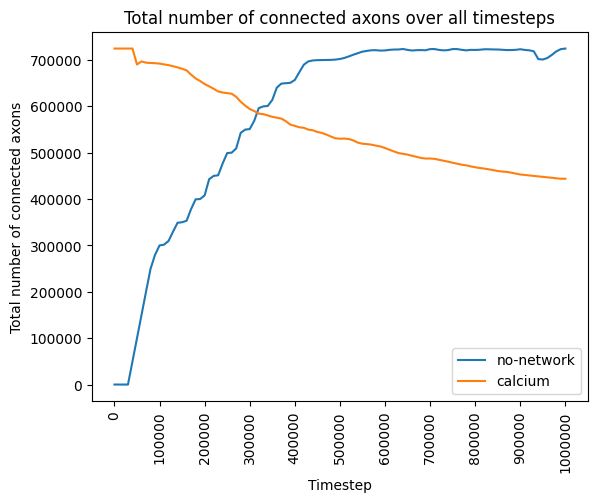

In [22]:
# Indicate dataset to process ('calcium', 'no-network')
simulations = ['no-network', 'calcium']

for sim in simulations:
    # Read positions file and clean up
    df_positions = clean_positions(f'data/viz-{sim}/positions/rank_0_positions.txt')

    # Read scalar data
    calcium = read_scalar_data(sim, 'calcium')
    connected_axons = read_scalar_data(sim, 'connected_axons')
    fired = read_scalar_data(sim, 'fired')
    x = read_scalar_data(sim, 'x')

    # Read calcium targets
    calcium_targets = read_calcium_targets(sim)

    # Process the data
    df_list = process_data(
        sim=sim,
        scalar_data=[calcium, connected_axons, fired, x],
        columns=['calcium', 'connected_axons', 'fired', 'x'],
        calcium_targets=calcium_targets,
        savefiles=False
    )

    # Plot the total number of connected axons over all timesteps
    summed_axons = [df['connected_axons'].sum() for df in df_list]
    
    plt.plot(summed_axons, label=sim)
    plt.xlabel('Timestep')
    plt.ylabel('Total number of connected axons')
    plt.xticks(np.arange(0, 101, 10), np.arange(0, 101, 10) * 10000, rotation=90)

plt.legend()
plt.title('Total number of connected axons over all timesteps')
plt.savefig('connected_axons.png', dpi=400, bbox_inches='tight')